In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.sql.functions import udf, explode, col
from pyspark.sql.types import ArrayType,StringType,IntegerType
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Lemmatization function from : https://stackoverflow.com/questions/59850159/nltk-wordnet-lemmatization-with-pos-tag-on-pyspark-dataframe

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpReview').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.executor.memory', '5g'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),

## Read Data

In [3]:
business = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .json("/user/ravim/yelp/yelp_academic_dataset_business.json")

business.printSchema()


root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [4]:
review = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .json("/user/ravim/yelp/yelp_academic_dataset_review.json")
review= review.withColumnRenamed("stars", "review_stars")
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



### Creation of Dataset using Joins

In [5]:
business_reviews=business.join(review, ["business_id"], 'left')

In [6]:
business_reviews_restaurants=business_reviews.filter(business_reviews.categories.contains('Restaurant'))

### EDA Sample

In [7]:
business_reviews_restaurants.groupby( 'city',"state").count().orderBy(["count"], ascending=[0]).show(10)

+----------+-----+------+
|      city|state| count|
+----------+-----+------+
|    Austin|   TX|807873|
|  Portland|   OR|752134|
|   Atlanta|   GA|600333|
|    Boston|   MA|532632|
|   Orlando|   FL|451805|
| Vancouver|   BC|305517|
|  Columbus|   OH|205332|
| Cambridge|   MA|159363|
|   Boulder|   CO| 74041|
|Somerville|   MA| 72704|
+----------+-----+------+
only showing top 10 rows



#### Change stars==5.0 for 5 star restaurants

In [8]:
rest_stars=business_reviews_restaurants.filter(business_reviews_restaurants.stars=='1.0').\
                                 groupBy('name','stars').count().sort("count").orderBy(["count"], \
                                                                                       ascending=[0]).limit(10)
rest_stars_df=rest_stars.toPandas()

In [9]:
rest_stars_df=rest_stars_df.sort_values(by=['count'])

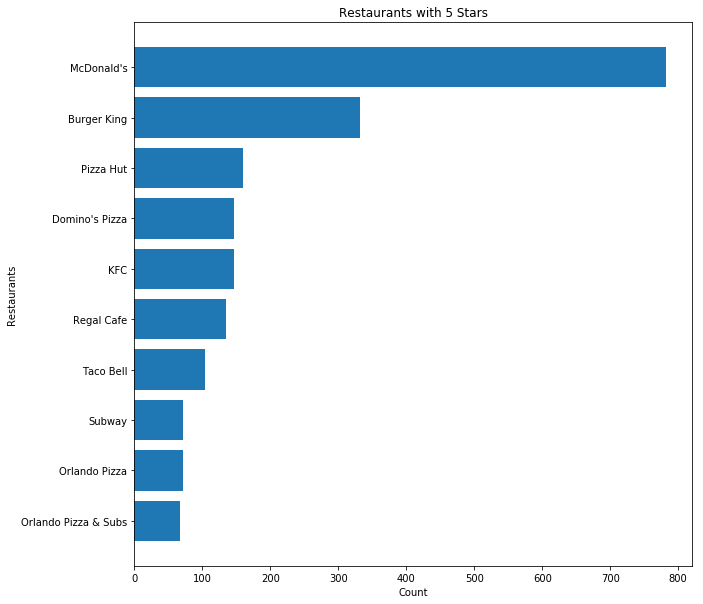

In [10]:
plt.figure(figsize=(10,10))
plt.barh(rest_stars_df['name'].tolist(),rest_stars_df['count'].tolist())
plt.title('Restaurants with 5 Stars')
plt.ylabel('Restaurants')
plt.xlabel('Count')

plt.show()

### Filtering

In [11]:
business_reviews_filtered=business_reviews_restaurants.filter(business_reviews_restaurants.name.contains("Pizza Hut")).filter\
(business_reviews_restaurants.state.contains('MA'))

In [12]:
business_reviews_filtered = business_reviews_filtered.distinct()

In [13]:
business_reviews_filtered.count()

256

In [14]:
business_reviews_cols=business_reviews_filtered.select('stars','text')

In [15]:
def pos_or_neg(stars):
    if stars >= 3.0: return 1
    else: return 0
label_stars=udf(pos_or_neg)

reviews_labeled = business_reviews_cols.withColumn("Target", label_stars("stars"))
reviews_labeled.show(5,truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Cleaning Reviews

In [16]:
def remove_non_ascii(data_str):
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

remove = udf(remove_non_ascii, StringType())

In [17]:
reviews_labeled = reviews_labeled.select('stars','Target','text',remove('text').\
            alias('text_cleaned'))

In [18]:
reviews_labeled.show(5)

+-----+------+--------------------+--------------------+
|stars|Target|                text|        text_cleaned|
+-----+------+--------------------+--------------------+
|  1.5|     0|Honestly I usuall...|Honestly I usuall...|
|  1.5|     0|I've see many neg...|I've see many neg...|
|  1.5|     0|Service is really...|Service is really...|
|  1.5|     0|Great pizza ! HOR...|Great pizza ! HOR...|
|  1.5|     0|So after my last ...|So after my last ...|
+-----+------+--------------------+--------------------+
only showing top 5 rows



In [19]:
#### Common stop words found in yelp data

In [20]:
remove_Words= [ "",'ourselves', 'hers', 'between', 'again', 'there', 'about', 'once', 
                       'during',  'very', 'having', 'with', 'they',  'some', 
                       'yours', 'such', 'into',  'most', 'itself', 'other',  
                       'from',  'each', 'wasn', 'themselves', 'until', 'below', 'these', 'your', 
                       'through', 'were',  'more', 'himself', 'this', 'down', 'should',
                       'their', 'while', 'above', 'both',  'ours', 'when', 
                       'before', 'them', 'same',  'been', 'have', 'will',  'does', 'yourselves', 'then',
                       'that', 'because', 'what', 'over', 'under', 
                       'herself',  'just', 'where',  'only', 'myself', 'which', 'those', 'after', 
                       'whom',  'being',  'theirs',  'against',  'doing',  'further',
                       'was', 'here', 'stars','gave','take']

In [21]:
stringsplit = udf(lambda line: [w for w in re.split("[^A-Za-z]", line.strip().lower()) if w not in remove_Words \
                                and len(w)>3], ArrayType(StringType()))

In [22]:
reviews_labeled = reviews_labeled.withColumn("remove_extra",stringsplit(reviews_labeled["text_cleaned"]))

In [23]:
reviews_labeled.show(5)

+-----+------+--------------------+--------------------+--------------------+
|stars|Target|                text|        text_cleaned|        remove_extra|
+-----+------+--------------------+--------------------+--------------------+
|  1.5|     0|Honestly I usuall...|Honestly I usuall...|[honestly, usuall...|
|  1.5|     0|I've see many neg...|I've see many neg...|[many, negative, ...|
|  1.5|     0|Service is really...|Service is really...|[service, really,...|
|  1.5|     0|Great pizza ! HOR...|Great pizza ! HOR...|[great, pizza, ho...|
|  1.5|     0|I always was told...|I always was told...|[always, told, re...|
+-----+------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [24]:
def pos_tagging(text):
    cleaned_str = ' '

    adjs = ['JJ', 'JJR', 'JJS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = adjs + verbs

    tagged = pos_tag(text)
    for word in tagged:
        if word[1] in nltk_tags:
            cleaned_str += word[0] + ' '
    return cleaned_str
pos_tagged = udf(pos_tagging)

In [25]:
reviews_labeled=reviews_labeled.withColumn("pos_tagging", pos_tagged("remove_extra"))

In [26]:
reviews_labeled.show(5)

+-----+------+--------------------+--------------------+--------------------+--------------------+
|stars|Target|                text|        text_cleaned|        remove_extra|         pos_tagging|
+-----+------+--------------------+--------------------+--------------------+--------------------+
|  1.5|     0|So after my last ...|So after my last ...|[last, review, ba...| last bashed staf...|
|  1.5|     0|Came here and the...|Came here and the...|[came, guys, look...| came guys high d...|
|  1.5|     0|I didn't expect a...|I didn't expect a...|[didn, expect, an...| expect phenomena...|
|  1.5|     0|I would typically...|I would typically...|[would, typically...| give good know c...|
|  1.5|     0|Honestly I usuall...|Honestly I usuall...|[honestly, usuall...| pizza took long ...|
+-----+------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [27]:
reviews_labeled=reviews_labeled.select("stars","text",'Target','pos_tagging')

### Tokenization

In [28]:
tokenizer = Tokenizer(inputCol="pos_tagging", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_labeled)


### Stop words remover

In [29]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsDataFrameUpdated = remover.transform(wordsDataFrame).select("text","Target","filtered")
wordsDataFrameUpdated.show(5)


+--------------------+------+--------------------+
|                text|Target|            filtered|
+--------------------+------+--------------------+
|If I could zero I...|     0|[, zero, open, te...|
|This is a small P...|     0|[, small, geared,...|
|Yeah I'm not wait...|     0|  [, waiting, pizza]|
|Wtf the staff her...|     0|[, fucking, rude,...|
|Walked in and wal...|     0|[, walked, walked...|
+--------------------+------+--------------------+
only showing top 5 rows



In [30]:
join_udf = udf(lambda x: " ".join(x))
pre_lemmatize=wordsDataFrameUpdated.withColumn("filtered_combined", join_udf(col("filtered")))
pre_lemmatize.show(5)

+--------------------+------+--------------------+--------------------+
|                text|Target|            filtered|   filtered_combined|
+--------------------+------+--------------------+--------------------+
|If I could zero I...|     0|[, zero, open, te...| zero open tell c...|
|This is a small P...|     0|[, small, geared,...| small geared bou...|
|Yeah I'm not wait...|     0|  [, waiting, pizza]|       waiting pizza|
|Wtf the staff her...|     0|[, fucking, rude,...| fucking rude mak...|
|Walked in and wal...|     0|[, walked, walked...| walked walked wa...|
+--------------------+------+--------------------+--------------------+
only showing top 5 rows



### Lemmatization

In [31]:
def lemmatize(data_str):
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str
lemmatization = udf(lemmatize, StringType())

In [32]:
lemmatized=pre_lemmatize.withColumn("lemmatized",lemmatization("filtered_combined")).select('text','lemmatized','Target')

In [33]:
lemmatized.show(5)

+--------------------+--------------------+------+
|                text|          lemmatized|Target|
+--------------------+--------------------+------+
|So after my last ...|last bash staffed...|     0|
|Came here and the...|come guy high dir...|     0|
|I didn't expect a...|expect phenomenal...|     0|
|I would typically...|give good know ca...|     0|
|Honestly I usuall...|pizza take long c...|     0|
+--------------------+--------------------+------+
only showing top 5 rows



In [34]:
model_data=lemmatized.select("lemmatized",'Target')

### Model Preparation: Train and Test Split

In [35]:
train_df, test_df = model_data.randomSplit([.7,.3],seed=1234)
train_df.show(10, truncate = True)

+--------------------+------+
|          lemmatized|Target|
+--------------------+------+
|       cashier treat|     0|
|come guy high dir...|     0|
| fuck rude make wear|     0|
|give good know ca...|     0|
|give hire appear ...|     0|
|good first take d...|     0|
|great horrible ru...|     0|
|horrible glad ord...|     0|
|last bash staffed...|     0|
|many negative thi...|     0|
+--------------------+------+
only showing top 10 rows



In [36]:
train_df = train_df.withColumn("Target", train_df["Target"].cast(IntegerType()))
test_df = test_df.withColumn("Target", test_df["Target"].cast(IntegerType()))

### Hashing NLP

In [37]:
tokenizer = Tokenizer(inputCol="lemmatized", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

### Model: Logistic Regression

In [38]:
logreg = LogisticRegression(maxIter=10, regParam=0.01,labelCol="Target",predictionCol="prediction")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, logreg])
model = pipeline.fit(train_df)

In [39]:
prediction = model.transform(test_df)

In [40]:
prediction.select("Target", "prediction").show(10,False)

+------+----------+
|Target|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
+------+----------+
only showing top 10 rows



In [41]:
evaluator = MulticlassClassificationEvaluator(labelCol='Target',predictionCol="prediction")
evaluator.evaluate(prediction)

0.908695652173913

### Model: Naive Bayes Model

In [42]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",labelCol="Target")
pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf, nb])
model_nb = pipeline_nb.fit(train_df)

In [43]:
prediction_nb = model_nb.transform(test_df)

In [44]:
prediction_nb.select("Target", "prediction").show(10,False)


+------+----------+
|Target|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
+------+----------+
only showing top 10 rows



In [45]:
evaluator_nb = MulticlassClassificationEvaluator(labelCol='Target',predictionCol="prediction")
evaluator_nb.evaluate(prediction_nb)

0.9256410256410257

### Visuals Prep

In [46]:
pos=model_data.filter(model_data.Target=='1')
neg=model_data.filter(model_data.Target=='0')

In [47]:
positive_words = pos.select('Target', stringsplit('lemmatized').alias('words')).withColumn('word', explode('words'))

In [48]:
negative_words = neg.select('Target', stringsplit('lemmatized').alias('words')).withColumn('word', explode('words'))

In [49]:
pos_words_count = positive_words.groupby('word').agg(F.count('Target').alias('word_count')).orderBy('word_count', ascending=False)

In [50]:
neg_words_count = negative_words.groupby('word').agg(F.count('Target').alias('word_count')).orderBy('word_count', ascending=False)

In [51]:
pos_words=pos_words_count.limit(100).toPandas()

In [52]:
neg_words=neg_words_count.limit(100).toPandas()

In [53]:
columns_titles = ["word_count","word"]
pos_words=pos_words.reindex(columns=columns_titles)

In [54]:
neg_words=neg_words.reindex(columns=columns_titles)

In [55]:
pos_words.to_csv("pos_words.csv",index=False,header=True)

In [56]:
neg_words.to_csv("neg_words.csv",index=False,header=True)

### Trying on LARGE sample

In [57]:
business_reviews_filtered=business_reviews_restaurants.filter(business_reviews_restaurants.state.contains('MA'))

In [58]:
business_reviews_filtered = business_reviews_filtered.distinct()

In [59]:
business_reviews_filtered.count()

1365575

In [60]:
business_reviews_cols=business_reviews_filtered.select('stars','text')

In [61]:
reviews_labeled = business_reviews_cols.withColumn("Target", label_stars("stars"))
reviews_labeled.show(5,truncate=False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|stars|text                                                                                                                                                                                                                                                                                                              

### Cleaning Reviews

In [62]:
reviews_labeled = reviews_labeled.select('stars','Target','text',remove('text').\
            alias('text_cleaned'))

In [63]:
reviews_labeled = reviews_labeled.withColumn("remove_extra",stringsplit(reviews_labeled["text_cleaned"]))

In [64]:
reviews_labeled=reviews_labeled.withColumn("pos_tagging", pos_tagged("remove_extra"))

In [65]:
reviews_labeled=reviews_labeled.select("stars","text",'Target','pos_tagging')

### Tokenization

In [66]:
tokenizer = Tokenizer(inputCol="pos_tagging", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_labeled)

### Stop words remover

In [67]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsDataFrameUpdated = remover.transform(wordsDataFrame).select("text","Target","filtered")

In [68]:
join_udf = udf(lambda x: " ".join(x))
pre_lemmatize=wordsDataFrameUpdated.withColumn("filtered_combined", join_udf(col("filtered")))

### Lemmatization

In [69]:
lemmatized=pre_lemmatize.withColumn("lemmatized",lemmatization("filtered_combined")).select('text','lemmatized','Target')

In [70]:
model_data=lemmatized.select("lemmatized",'Target')

### Model Preparation: Train and Test Split

In [71]:
train_df, test_df = model_data.randomSplit([.7,.3],seed=1234)

In [72]:
train_df = train_df.withColumn("Target", train_df["Target"].cast(IntegerType()))
test_df = test_df.withColumn("Target", test_df["Target"].cast(IntegerType()))

### Hashing NLP

In [73]:
tokenizer = Tokenizer(inputCol="lemmatized", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

### Model: Logistic Regression

In [74]:
logreg = LogisticRegression(maxIter=10, regParam=0.01,labelCol="Target",predictionCol="prediction")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, logreg])
model = pipeline.fit(train_df)

In [75]:
prediction = model.transform(test_df)

In [76]:
prediction.select("Target", "prediction").show(10,False)

+------+----------+
|Target|prediction|
+------+----------+
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
|1     |1.0       |
+------+----------+
only showing top 10 rows



In [77]:
evaluator = MulticlassClassificationEvaluator(labelCol='Target',predictionCol="prediction")
evaluator.evaluate(prediction)

0.9154304935982607

### Model: Naive Bayes Model

In [78]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",labelCol="Target")
pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf, nb])
model_nb = pipeline_nb.fit(train_df)

In [79]:
prediction_nb = model_nb.transform(test_df)

In [80]:
evaluator_nb = MulticlassClassificationEvaluator(labelCol='Target',predictionCol="prediction")
evaluator_nb.evaluate(prediction_nb)

0.8575762093318139

### Visual Prep

In [81]:
pos=model_data.filter(model_data.Target=='1')
neg=model_data.filter(model_data.Target=='0')

In [82]:
positive_words = pos.select('Target', stringsplit('lemmatized').alias('words')).withColumn('word', explode('words'))

In [83]:
negative_words = neg.select('Target', stringsplit('lemmatized').alias('words')).withColumn('word', explode('words'))

In [84]:
pos_words_count = positive_words.groupby('word').agg(F.count('Target').alias('word_count')).orderBy('word_count', ascending=False)

In [85]:
neg_words_count = negative_words.groupby('word').agg(F.count('Target').alias('word_count')).orderBy('word_count', ascending=False)

In [86]:
pos_words=pos_words_count.limit(100).toPandas()

In [87]:
neg_words=neg_words_count.limit(100).toPandas()

In [88]:
columns_titles = ["word_count","word"]
pos_words=pos_words.reindex(columns=columns_titles)

In [89]:
import numpy as np

In [90]:
pos_words['word_count']=(pos_words['word_count']/100).astype(np.int64)

In [91]:
neg_words=neg_words.reindex(columns=columns_titles)

In [92]:
neg_words['word_count']=(neg_words['word_count']/100).astype(np.int64)

In [93]:
pos_words.to_csv("pos_words_large.csv",index=False,header=True)

In [94]:
neg_words.to_csv("neg_words_large.csv",index=False,header=True)

## Topic Modeling

In [34]:
review_business_loc = review.select('business_id', 'user_id',"text",'stars')
business_loc = business.select('business_id', 'city',"state","categories")
business_reviews_loc = review_business_loc.join(business_loc, ["business_id"], 'left')

In [35]:
business_reviews_loc.show(10)

+--------------------+--------------------+--------------------+-----+-----------------+-----+--------------------+
|         business_id|             user_id|                text|stars|             city|state|          categories|
+--------------------+--------------------+--------------------+-----+-----------------+-----+--------------------+
|buF9druCkbuXLX526...|ak0TdVmGKo4pwqdJS...|Apparently Prides...|  4.0|          Beverly|   MA|Restaurants, Wine...|
|RA4V8pr014UyUbDvI...|YoVfDbnISlW0f7abN...|This store is pre...|  4.0|       Framingham|   MA|Department Stores...|
|_sS2LBIGNT5NQb6PD...|eC5evKn1TWDyHCyQA...|I called WVM on t...|  5.0|         Portland|   OR|Home Services, Pa...|
|0AzLzHfOJgL7ROwhd...|SFQ1jcnGguO0LYWnb...|I've stayed at ma...|  2.0|          Orlando|   FL|Hotels, Hotels & ...|
|8zehGz9jnxPqXtOc7...|0kA0PAJ8QFMeveQWH...|The food is alway...|  4.0|          Boulder|   CO| Restaurants, French|
|xGXzsc-hzam-VArK6...|RNm_RWkcd02Li2mKP...|This place used t...|  1.0|  

In [36]:
business_reviews_loc.count()

8635403

#### Filter for Boston Restaurants

In [37]:
df = business_reviews_loc.filter(business_reviews_loc.categories.like("Restaurant%"))
df.count()

1378952

In [38]:
df = df.filter(business_reviews_loc.city =="Boston")
df.count()

132168

In [39]:
df_positive = df.filter(df.stars == 5).select("text")
df_positive.count()

43152

In [40]:
df_negative = df.filter(df.stars == 1).select("text")
df_negative.count()

14732

In [41]:
df_negative.show()

+--------------------+
|                text|
+--------------------+
|Over the years, I...|
|Wouldn't let some...|
|Review is for foo...|
|We ordered after ...|
|Rating take-out. ...|
|This was a really...|
|Go to Starbucks i...|
|Insofar as this i...|
|I wish I had the ...|
|This place should...|
|Pizza/experience ...|
|We went for after...|
|I just ordered on...|
|Had takeout last ...|
|Overrated pizza. ...|
|Was here this pas...|
|I end up ordering...|
|I went there last...|
|My girlfriend and...|
|This is the most ...|
+--------------------+
only showing top 20 rows



### Topic Modeling - negative reviews

In [42]:
from pyspark.ml.feature import Tokenizer

#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_negative = tokenizer.transform(df_negative)

#drop the redundant source column
df_negative.show(5)

+--------------------+--------------------+
|                text|               words|
+--------------------+--------------------+
|Over the years, I...|[over, the, years...|
|Wouldn't let some...|[wouldn't, let, s...|
|Review is for foo...|[review, is, for,...|
|We ordered after ...|[we, ordered, aft...|
|Rating take-out. ...|[rating, take-out...|
+--------------------+--------------------+
only showing top 5 rows



In [43]:
from pyspark.ml.feature import StopWordsRemover

#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_negative = remover.transform(df_negative)

#drop the redundant source column
df_negative= df_negative.drop("words")
df_negative.show(5)

+--------------------+--------------------+
|                text|            filtered|
+--------------------+--------------------+
|Over the years, I...|[years,, burger, ...|
|Wouldn't let some...|[let, someone, gr...|
|Review is for foo...|[review, food, on...|
|We ordered after ...|[ordered, seeing,...|
|Rating take-out. ...|[rating, take-out...|
+--------------------+--------------------+
only showing top 5 rows



In [44]:
from pyspark.ml.feature import CountVectorizer
Vector = CountVectorizer(inputCol="filtered", outputCol="features")
model = Vector.fit(df_negative)
result = model.transform(df_negative)
result.show(5)

+--------------------+--------------------+--------------------+
|                text|            filtered|            features|
+--------------------+--------------------+--------------------+
|Over the years, I...|[years,, burger, ...|(70685,[0,3,9,11,...|
|Wouldn't let some...|[let, someone, gr...|(70685,[119,125,2...|
|Review is for foo...|[review, food, on...|(70685,[0,1,2,6,9...|
|We ordered after ...|[ordered, seeing,...|(70685,[1,5,8,13,...|
|Rating take-out. ...|[rating, take-out...|(70685,[4,8,14,34...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [45]:
model.vocabulary

['',
 'food',
 'place',
 'us',
 'like',
 'one',
 'get',
 'even',
 'ordered',
 'never',
 'service',
 'go',
 'came',
 'got',
 'order',
 'back',
 'time',
 'restaurant',
 'asked',
 'good',
 'said',
 'minutes',
 'told',
 '-',
 'went',
 'people',
 'table',
 'really',
 'waitress',
 'come',
 'it.',
 'took',
 'first',
 'bad',
 'two',
 'going',
 'another',
 'give',
 'chicken',
 'know',
 'ever',
 'make',
 'worst',
 'want',
 'also',
 'take',
 'eat',
 'made',
 'wait',
 'better',
 'still',
 'much',
 'experience',
 'way',
 'manager',
 'bar',
 'food.',
 'pizza',
 'staff',
 'waiter',
 '2',
 'around',
 'server',
 'wanted',
 'think',
 'say',
 'left',
 'last',
 'waiting',
 'called',
 'great',
 'ask',
 'since',
 'friend',
 'tasted',
 'customer',
 'next',
 'rude',
 'menu',
 'service.',
 'waited',
 'long',
 'night',
 'put',
 'see',
 'drinks',
 'boston',
 'half',
 'something',
 'walked',
 'try',
 'nothing',
 'place.',
 'hour',
 'meal',
 'pretty',
 'sure',
 'many',
 'right',
 'finally',
 'again.',
 'gave',
 'h

In [46]:
vocab = model.vocabulary

In [47]:
from pyspark.sql.functions import monotonically_increasing_id 

result = result.select("*").withColumn("id", monotonically_increasing_id())
result.show(5)

+--------------------+--------------------+--------------------+---+
|                text|            filtered|            features| id|
+--------------------+--------------------+--------------------+---+
|Over the years, I...|[years,, burger, ...|(70685,[0,3,9,11,...|  0|
|Wouldn't let some...|[let, someone, gr...|(70685,[119,125,2...|  1|
|Review is for foo...|[review, food, on...|(70685,[0,1,2,6,9...|  2|
|We ordered after ...|[ordered, seeing,...|(70685,[1,5,8,13,...|  3|
|Rating take-out. ...|[rating, take-out...|(70685,[4,8,14,34...|  4|
+--------------------+--------------------+--------------------+---+
only showing top 5 rows



In [48]:
result = result.drop("text","filtered")

result.show(5)

+--------------------+---+
|            features| id|
+--------------------+---+
|(70685,[0,3,9,11,...|  0|
|(70685,[119,125,2...|  1|
|(70685,[0,1,2,6,9...|  2|
|(70685,[1,5,8,13,...|  3|
|(70685,[4,8,14,34...|  4|
+--------------------+---+
only showing top 5 rows



In [49]:
from pyspark.ml.clustering import LDA

lda = LDA(k=10, seed=1, optimizer="em")
ldamodel = lda.fit(result)


In [50]:
ldaModel = ldamodel.toLocal()
ldaModel.isDistributed()

False

In [51]:
ldamodel.vocabSize()

70685

In [52]:
topics = ldamodel.describeTopics()
topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 2, 3, 4, 5...|[0.05108257579102...|
|    1|[0, 1, 3, 2, 4, 5...|[0.04870055714373...|
|    2|[0, 1, 3, 2, 4, 5...|[0.04572837781564...|
|    3|[0, 1, 3, 4, 2, 5...|[0.04120997490061...|
|    4|[0, 1, 3, 4, 2, 5...|[0.04975630719597...|
|    5|[0, 1, 2, 4, 3, 5...|[0.05489565127027...|
|    6|[0, 1, 2, 4, 3, 5...|[0.05162144043425...|
|    7|[0, 1, 2, 3, 4, 5...|[0.05924211820471...|
|    8|[0, 1, 3, 2, 4, 5...|[0.04667651383880...|
|    9|[0, 1, 2, 4, 5, 3...|[0.05610422621995...|
+-----+--------------------+--------------------+



In [53]:
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: ", idx)
    print("----------")

    for word in topic:
        print(word)
        print("----------")

topic:  0
----------

----------
food
----------
place
----------
us
----------
like
----------
one
----------
get
----------
ordered
----------
even
----------
never
----------
topic:  1
----------

----------
food
----------
us
----------
place
----------
like
----------
one
----------
get
----------
even
----------
never
----------
ordered
----------
topic:  2
----------

----------
food
----------
us
----------
place
----------
like
----------
one
----------
get
----------
even
----------
ordered
----------
service
----------
topic:  3
----------

----------
food
----------
us
----------
like
----------
place
----------
one
----------
get
----------
even
----------
never
----------
ordered
----------
topic:  4
----------

----------
food
----------
us
----------
like
----------
place
----------
one
----------
get
----------
ordered
----------
even
----------
never
----------
topic:  5
----------

----------
food
----------
place
----------
like
----------
us
----------
one
--------

In [54]:
topics_words

[['', 'food', 'place', 'us', 'like', 'one', 'get', 'ordered', 'even', 'never'],
 ['', 'food', 'us', 'place', 'like', 'one', 'get', 'even', 'never', 'ordered'],
 ['',
  'food',
  'us',
  'place',
  'like',
  'one',
  'get',
  'even',
  'ordered',
  'service'],
 ['', 'food', 'us', 'like', 'place', 'one', 'get', 'even', 'never', 'ordered'],
 ['', 'food', 'us', 'like', 'place', 'one', 'get', 'ordered', 'even', 'never'],
 ['',
  'food',
  'place',
  'like',
  'us',
  'one',
  'get',
  'even',
  'ordered',
  'service'],
 ['', 'food', 'place', 'like', 'us', 'one', 'get', 'even', 'ordered', 'never'],
 ['', 'food', 'place', 'us', 'like', 'one', 'get', 'even', 'never', 'service'],
 ['', 'food', 'us', 'place', 'like', 'one', 'get', 'even', 'never', 'ordered'],
 ['', 'food', 'place', 'like', 'one', 'us', 'get', 'ordered', 'even', 'never']]

In [55]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [56]:
lst = flatten(topics_words)

In [57]:
lst = [x for x in lst if len(x)>2]

In [58]:
from pyspark.sql.types import StructType, IntegerType, StringType

df1 = spark.createDataFrame(lst, StringType())
df1 = df1.toPandas()
df1.head(15)

,value
0,food
1,place
2,like
3,one
4,get
5,ordered
6,even
7,never
8,food
9,place


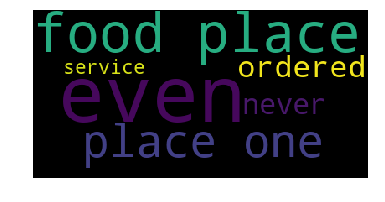

In [59]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

fields = ['value']
stopwords = set(STOPWORDS) 


text = ' '.join(df1['value'])
wordcloud2 = WordCloud(stopwords = stopwords).generate(text)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

### Topic Modeling - positive reviews

In [60]:
from pyspark.ml.feature import Tokenizer

#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_positive = tokenizer.transform(df_positive)

#drop the redundant source column
df_positive.show(5)

+--------------------+--------------------+
|                text|               words|
+--------------------+--------------------+
|Love this place! ...|[love, this, plac...|
|To say that I am ...|[to, say, that, i...|
|We went there for...|[we, went, there,...|
|My husband is fro...|[my, husband, is,...|
|Would I drive hou...|[would, i, drive,...|
+--------------------+--------------------+
only showing top 5 rows



In [61]:
from pyspark.ml.feature import StopWordsRemover

#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_positive = remover.transform(df_positive)

#drop the redundant source column
df_positive= df_positive.drop("words")
df_positive.show(5)

+--------------------+--------------------+
|                text|            filtered|
+--------------------+--------------------+
|Love this place! ...|[love, place!, fo...|
|To say that I am ...|[say, love, thait...|
|We went there for...|[went, restaurant...|
|My husband is fro...|[husband, bolivia...|
|Would I drive hou...|[drive, hours, pi...|
+--------------------+--------------------+
only showing top 5 rows



In [62]:
from pyspark.ml.feature import CountVectorizer
Vector = CountVectorizer(inputCol="filtered", outputCol="features")
model = Vector.fit(df_positive)
result = model.transform(df_positive)
result.show(5)

+--------------------+--------------------+--------------------+
|                text|            filtered|            features|
+--------------------+--------------------+--------------------+
|Love this place! ...|[love, place!, fo...|(112644,[0,2,4,9,...|
|To say that I am ...|[say, love, thait...|(112644,[0,1,2,3,...|
|We went there for...|[went, restaurant...|(112644,[2,5,10,1...|
|My husband is fro...|[husband, bolivia...|(112644,[0,2,3,4,...|
|Would I drive hou...|[drive, hours, pi...|(112644,[1,3,4,6,...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [63]:
model.vocabulary

['',
 'great',
 'food',
 'place',
 'good',
 'best',
 'one',
 'like',
 'get',
 'really',
 'also',
 '-',
 'go',
 'service',
 'love',
 'definitely',
 'back',
 'time',
 'got',
 'always',
 'restaurant',
 'boston',
 'chicken',
 'delicious',
 'lobster',
 'ordered',
 'nice',
 'even',
 'try',
 'us',
 'come',
 'came',
 'little',
 'everything',
 'recommend',
 'pizza',
 'fresh',
 'staff',
 'it.',
 'menu',
 'went',
 'amazing',
 'made',
 'order',
 'first',
 'favorite',
 'ever',
 'make',
 'wait',
 'every',
 'friendly',
 'well',
 'never',
 'much',
 'delicious.',
 'eat',
 'good.',
 'worth',
 'perfect',
 'dinner',
 'people',
 'super',
 'boston.',
 'lunch',
 'right',
 'bar',
 'loved',
 'two',
 'food.',
 'want',
 'new',
 'highly',
 'small',
 'pretty',
 'sauce',
 'next',
 'tried',
 'night',
 'going',
 '&',
 'take',
 'many',
 'know',
 'place.',
 'think',
 'meal',
 'fried',
 'around',
 'still',
 'excellent',
 'sure',
 'cheese',
 'say',
 'hot',
 'since',
 'food,',
 'amazing.',
 'way',
 'table',
 'absolutely',

In [64]:
vocab = model.vocabulary

In [65]:
from pyspark.sql.functions import monotonically_increasing_id 

result = result.select("*").withColumn("id", monotonically_increasing_id())
result.show(5)

+--------------------+--------------------+--------------------+---+
|                text|            filtered|            features| id|
+--------------------+--------------------+--------------------+---+
|Love this place! ...|[love, place!, fo...|(112644,[0,2,4,9,...|  0|
|To say that I am ...|[say, love, thait...|(112644,[0,1,2,3,...|  1|
|We went there for...|[went, restaurant...|(112644,[2,5,10,1...|  2|
|My husband is fro...|[husband, bolivia...|(112644,[0,2,3,4,...|  3|
|Would I drive hou...|[drive, hours, pi...|(112644,[1,3,4,6,...|  4|
+--------------------+--------------------+--------------------+---+
only showing top 5 rows



In [66]:
result = result.drop("text","filtered")

result.show(5)

+--------------------+---+
|            features| id|
+--------------------+---+
|(112644,[0,2,4,9,...|  0|
|(112644,[0,1,2,3,...|  1|
|(112644,[2,5,10,1...|  2|
|(112644,[0,2,3,4,...|  3|
|(112644,[1,3,4,6,...|  4|
+--------------------+---+
only showing top 5 rows



In [67]:
from pyspark.ml.clustering import LDA

lda = LDA(k=10, seed=1, optimizer="em")
ldamodel = lda.fit(result)


In [68]:
ldaModel = ldamodel.toLocal()
ldaModel.isDistributed()

False

In [69]:
ldamodel.vocabSize()

112644

In [70]:
topics = ldamodel.describeTopics()
topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 2, 3, 4, 5...|[0.05555019868550...|
|    1|[0, 1, 2, 3, 4, 5...|[0.05504755621239...|
|    2|[0, 1, 2, 3, 4, 5...|[0.04728884631278...|
|    3|[0, 1, 2, 3, 4, 5...|[0.06444600728077...|
|    4|[0, 1, 2, 3, 4, 5...|[0.04639148789217...|
|    5|[0, 1, 2, 3, 4, 5...|[0.04491704630617...|
|    6|[0, 2, 1, 3, 4, 1...|[0.06653099136808...|
|    7|[0, 1, 2, 3, 4, 5...|[0.04624851851433...|
|    8|[0, 1, 2, 3, 4, 5...|[0.04226122570119...|
|    9|[0, 1, 2, 3, 4, 5...|[0.05501752489920...|
+-----+--------------------+--------------------+



In [71]:
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: ", idx)
    print("----------")

    for word in topic:
        print(word)
        print("----------")

topic:  0
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
one
----------
like
----------
get
----------
also
----------
topic:  1
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
one
----------
get
----------
like
----------
also
----------
topic:  2
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
get
----------
one
----------
like
----------
really
----------
topic:  3
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
one
----------
-
----------
like
----------
get
----------
topic:  4
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
one
----------
get
----------
like
----------
also
----------
topic:  5
----------

----------
great
----------
food
----------
place
----------
good
----------
best
----------
o

In [72]:
topics_words

[['', 'great', 'food', 'place', 'good', 'best', 'one', 'like', 'get', 'also'],
 ['', 'great', 'food', 'place', 'good', 'best', 'one', 'get', 'like', 'also'],
 ['',
  'great',
  'food',
  'place',
  'good',
  'best',
  'get',
  'one',
  'like',
  'really'],
 ['', 'great', 'food', 'place', 'good', 'best', 'one', '-', 'like', 'get'],
 ['', 'great', 'food', 'place', 'good', 'best', 'one', 'get', 'like', 'also'],
 ['', 'great', 'food', 'place', 'good', 'best', 'one', 'get', 'like', '-'],
 ['', 'food', 'great', 'place', 'good', '-', 'best', 'like', 'one', 'get'],
 ['',
  'great',
  'food',
  'place',
  'good',
  'best',
  'like',
  'one',
  'get',
  'really'],
 ['', 'great', 'food', 'place', 'good', 'best', 'like', 'get', 'one', 'also'],
 ['', 'great', 'food', 'place', 'good', 'best', 'like', 'one', 'get', 'also']]

In [73]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [74]:
lst = flatten(topics_words)

In [75]:
lst = [x for x in lst if len(x)>2]

In [76]:
df1 = spark.createDataFrame(lst, StringType())
df1 = df1.toPandas()
df1.head(15)

,value
0,great
1,food
2,place
3,good
4,best
5,one
6,like
7,get
8,also
9,great


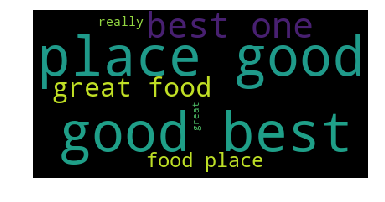

In [77]:
fields = ['value']
stopwords = set(STOPWORDS) 


text = ' '.join(df1['value'])
wordcloud2 = WordCloud(stopwords = stopwords).generate(text)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [78]:
df_negative.show()

+--------------------+--------------------+
|                text|            filtered|
+--------------------+--------------------+
|Over the years, I...|[years,, burger, ...|
|Wouldn't let some...|[let, someone, gr...|
|Review is for foo...|[review, food, on...|
|We ordered after ...|[ordered, seeing,...|
|Rating take-out. ...|[rating, take-out...|
|This was a really...|[really, disappoi...|
|Go to Starbucks i...|[go, starbucks, w...|
|Insofar as this i...|[insofar, terribl...|
|I wish I had the ...|[wish, opportunit...|
|This place should...|[place, update, a...|
|Pizza/experience ...|[pizza/experience...|
|We went for after...|[went, afternoon,...|
|I just ordered on...|[ordered, online,...|
|Had takeout last ...|[takeout, last, n...|
|Overrated pizza. ...|[overrated, pizza...|
|Was here this pas...|[past, weekend, s...|
|I end up ordering...|[end, ordering, p...|
|I went there last...|[went, last, nigh...|
|My girlfriend and...|[girlfriend, went...|
|This is the most ...|[discrimin